# Non-standard string literals

Example: Write rationals using standard syntax (1/3)

In [1]:
macro rat_str(s)
    @show s
    return nothing
end

@rat_str (macro with 1 method)

In [2]:
rat"1/3"

s = "1/3"


In [9]:
macro rat_str(s)
    # @show s
    
    !contains(s, "/") && throw(ArgumentError("Must contain /"))
    
    num, den = split(s, "/")
    
    # @show num, den
    
    n, d = parse.((num, den))
    
    return Rational(n, d)
    
end

@rat_str (macro with 1 method)

In [10]:
rat"1 / 3"

1//3

- Metaprogramming: Access to structure of code expressions
- Macros
- MacroTools.jl

# Expressions and syntax trees

A Julia expression is an unevaluated tree of symbols. We can create an expression object using `:(...)` or `quote`:

In [29]:
ex = :(x^2 + y^2)

:(x ^ 2 + y ^ 2)

In [30]:
ex = quote
        x^2 + y^2
end

quote  # In[30], line 2:
    x ^ 2 + y ^ 2
end

We can see the internal structure with `dump` or `Meta.show_sexpr`:

In [27]:
dump(ex)

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol +
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol x
        3: Int64 2
      typ: Any
    3: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol ^
        2: Symbol y
        3: Int64 2
      typ: Any
  typ: Any


In [28]:
Meta.show_sexpr(ex)

(:call, :+, (:call, :^, :x, 2), (:call, :^, :y, 2))

We can also see it visually with the `TreeView` package I wrote:

In [3]:
Pkg.add("TreeView")  # needs LaTeX installed on your system

INFO: Package TreeView is already installed
INFO: METADATA is out-of-date — you may not have the latest version of TreeView
INFO: Use `Pkg.update()` to get the latest versions of your packages


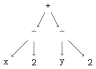

In [6]:
using TreeView

@tree x^2 + y^2

## Walking a tree

We can walk through a tree recursively:

In [17]:
function traverse(ex)
    println("Found $ex")
end
        

function traverse(ex::Expr)
    println("Processing expression with head $(ex.head)")
    
    for arg in ex.args
        println("Processing argument $arg")
        
        traverse(arg)  # recursive
    end
end
   

traverse (generic function with 2 methods)

In [18]:
traverse(:(x^2 + y^2))

Processing expression with head call
Processing argument +
Found +
Processing argument x ^ 2
Processing expression with head call
Processing argument ^
Found ^
Processing argument x
Found x
Processing argument 2
Found 2
Processing argument y ^ 2
Processing expression with head call
Processing argument ^
Found ^
Processing argument y
Found y
Processing argument 2
Found 2


## Exercise

Return a list of all the (non-numeric) symbols in the expression. Hint: you will need to keep track of all the symbols seen so far. 

## Solution to the exercise 

In [7]:
function traverse!(ex, symbols)
    # nothing here!
end

function traverse!(ex::Symbol, symbols)
    push!(symbols, ex)
end
        

function traverse!(ex::Expr, symbols)
    
    if ex.head == :call  # function call
        
        for arg in ex.args[2:end]
            traverse!(arg, symbols)  # recursive
        end
        
    else
    
        for arg in ex.args
            traverse!(arg, symbols)  # recursive
        end
    end
end

function traverse(ex::Expr) 
    symbols = Symbol[]
    traverse!(ex, symbols)
    
    return symbols
end
    

traverse (generic function with 1 method)

In [9]:
Meta.show_sexpr(:(3 + 4))

(:call, :+, 3, 4)

In [8]:
traverse(:(x^2 + y^2))

2-element Array{Symbol,1}:
 :x
 :y

In [12]:
traverse(:(x^2 + y^2 + x))

3-element Array{Symbol,1}:
 :x
 :y
 :x

## Exercise

Remove the duplication in the list.

## Building a function

Now let's build a function using the list of symbols:

In [13]:
function build_function(ex::Expr)
    symbols = unique(traverse(ex))
    
    symbol_tuple = Expr(:tuple, symbols...)
end

build_function (generic function with 1 method)

In [14]:
build_function(:(x^2 + y^2))

:((x, y))

In [17]:
function build_function(ex::Expr)
    symbols = unique(traverse(ex))
    
    symbol_tuple = Expr(:tuple, symbols...)
    
    :($symbol_tuple -> $ex)
end

build_function (generic function with 1 method)

In [18]:
build_function(:(x^2 + y^2 + x))

:((x, y)->begin  # In[17], line 6:
            x ^ 2 + y ^ 2 + x
        end)

# Macros

To make this user-friendly, we need to write a **macro**. 
This is a kind of "super-function": it takes as argument an expression, from which it calculates a new expression.
When the macro returns, the new expression is **automatically evaluated**.    

Furthermore, the argument of the macro is **automatically converted** into an `Expr` object:

In [19]:
macro make_function(ex)
    return build_function(ex)
end

@make_function (macro with 1 method)

In [21]:
f = @make_function x^2 + y^2 + x

(::#3) (generic function with 1 method)

In [22]:
f(3, 4)

28

We can use `@macroexpand` to see what effect a macro has:

The macro **replaces** the original piece of code before the new piece, before any evaluation takes place.